In [1]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)


In [2]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


In [3]:
kaggle_credentails = json.load(open("kaggle.json"))


In [4]:

# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [6]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [01:30<00:00, 24.4MB/s]
100% 1.96G/1.96G [01:30<00:00, 23.3MB/s]


In [7]:
# Unzip the downloaded dataset
with ZipFile("/content/100-bird-species.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
 "/content/train",
    image_size=(224, 224),
    batch_size=32)
test_dataset = image_dataset_from_directory(
   "/content/test",
    image_size=(224, 224),
    batch_size=32)
validata = image_dataset_from_directory(
   "/content/valid",
    image_size=(224, 224),
    batch_size=32)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [29]:
# Rescale
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# data transfer from directories to batches
train_data = train_datagen.flow_from_directory(directory = "/content/train",
                                               batch_size= 32,
                                               target_size= (224,224),
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(directory = "/content/test",
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "categorical")

val_data = valid_datagen.flow_from_directory(directory = "/content/valid",
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "categorical")

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [10]:
import pathlib
import numpy as np

data_dir = pathlib.Path("/content/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # creating a list of class names from subdirectory
print(class_names[1:10])

['ABBOTTS BOOBY' 'ABYSSINIAN GROUND HORNBILL' 'AFRICAN CROWNED CRANE'
 'AFRICAN EMERALD CUCKOO' 'AFRICAN FIREFINCH' 'AFRICAN OYSTER CATCHER'
 'AFRICAN PIED HORNBILL' 'AFRICAN PYGMY GOOSE' 'ALBATROSS']


In [14]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.6 MB/s eta 0:00:00


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet50, EfficientNetB0, MobileNetV2, DenseNet121
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [27]:
def create_model(base_model):
    # Remove the top layer
    base_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # Add a logistic layer with 525 output units (one for each bird species)
    predictions = Dense(525, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=[F1Score(num_classes=525, average='macro'), 'accuracy'])

    return model

In [31]:
# List of base models
base_models = [InceptionV3, ResNet50, EfficientNetB0, MobileNetV2, DenseNet121]

# Dictionary to store models and their names
models = {}

for model_name, base_model in zip(['InceptionV3', 'ResNet50', 'EfficientNetB0', 'MobileNetV2', 'DenseNet121'], base_models):
    # Create and compile the model
    model = create_model(base_model(weights='imagenet', include_top=False))
    models[model_name] = model

    # Train the model
    history = model.fit(train_data, steps_per_epoch=len(train_data), validation_data=val_data, validation_steps=len(val_data), epochs=5)

    # Optionally, save the model for later use
    model.save(f'{model_name}_model.h5')

Epoch 1/5
2645/2645 [==============================] - 214s 79ms/step - loss: 3.6790 - f1_score: 0.3551 - accuracy: 0.3633 - val_loss: 2.2075 - val_f1_score: 0.5628 - val_accuracy: 0.5874
Epoch 2/5
2645/2645 [==============================] - 198s 75ms/step - loss: 1.9228 - f1_score: 0.6034 - accuracy: 0.6136 - val_loss: 1.4673 - val_f1_score: 0.6799 - val_accuracy: 0.6949
Epoch 3/5
2645/2645 [==============================] - 200s 76ms/step - loss: 1.4752 - f1_score: 0.6732 - accuracy: 0.6789 - val_loss: 1.1850 - val_f1_score: 0.7167 - val_accuracy: 0.7269
Epoch 4/5
2645/2645 [==============================] - 199s 75ms/step - loss: 1.2545 - f1_score: 0.7106 - accuracy: 0.7143 - val_loss: 1.0324 - val_f1_score: 0.7528 - val_accuracy: 0.7627
Epoch 5/5
2645/2645 [==============================] - 199s 75ms/step - loss: 1.1168 - f1_score: 0.7378 - accuracy: 0.7406 - val_loss: 0.9344 - val_f1_score: 0.7614 - val_accuracy: 0.7699


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/5
2645/2645 [==============================] - 309s 115ms/step - loss: 6.2779 - f1_score: 1.4038e-04 - accuracy: 0.0026 - val_loss: 6.2634 - val_f1_score: 7.2424e-06 - val_accuracy: 0.0019
Epoch 2/5
2645/2645 [==============================] - 299s 113ms/step - loss: 6.2622 - f1_score: 2.1283e-05 - accuracy: 0.0030 - val_loss: 6.2635 - val_f1_score: 7.2424e-06 - val_accuracy: 0.0019
Epoch 3/5
2645/2645 [==============================] - 300s 113ms/step - loss: 6.2614 - f1_score: 3.6668e-05 - accuracy: 0.0031 - val_loss: 6.2636 - val_f1_score: 7.2424e-06 - val_accuracy: 0.0019
Epoch 4/5
2645/2645 [==============================] - 298s 113ms/step - loss: 6.2607 - f1_score: 1.1801e-05 - accuracy: 0.0031 - val_loss: 6.2638 - val_f1_score: 7.2424e-06 - val_accuracy: 0.0019
Epoch 5/5
16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/5
2645/2645 [==============================] - 202s 73ms/step - 

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/5
2645/2645 [==============================] - 186s 69ms/step - loss: 2.8522 - f1_score: 0.4028 - accuracy: 0.4067 - val_loss: 1.2947 - val_f1_score: 0.6497 - val_accuracy: 0.6640
Epoch 2/5
2645/2645 [==============================] - 169s 64ms/step - loss: 1.1912 - f1_score: 0.6905 - accuracy: 0.6924 - val_loss: 0.9477 - val_f1_score: 0.7364 - val_accuracy: 0.7444
Epoch 3/5
2645/2645 [==============================] - 184s 69ms/step - loss: 0.9160 - f1_score: 0.7550 - accuracy: 0.7561 - val_loss: 0.7971 - val_f1_score: 0.7725 - val_accuracy: 0.7798
Epoch 4/5
2645/2645 [==============================] - 173s 66ms/step - loss: 0.7620 - f1_score: 0.7932 - accuracy: 0.7940 - val_loss: 0.7076 - val_f1_score: 0.7951 - val_accuracy: 0.8038
Epoch 5/5
29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/5
2645/2645 [==============================] - 287s 105ms/step - loss: 2.0102 - f1_score: 0.6236 - acc

In [32]:
models.items()


dict_items([('InceptionV3', <keras.src.engine.functional.Functional object at 0x7e84245ad840>), ('ResNet50', <keras.src.engine.functional.Functional object at 0x7e83606c5450>), ('EfficientNetB0', <keras.src.engine.functional.Functional object at 0x7e8424b08d90>), ('MobileNetV2', <keras.src.engine.functional.Functional object at 0x7e835f6a1120>), ('DenseNet121', <keras.src.engine.functional.Functional object at 0x7e8424a6af50>)])

In [33]:
for model_name, model in models.items():

    # Generate predictions
    y_prob = model.predict(test_data)
    y_pred = np.argmax(y_prob, axis=1)

    # Extract true labels
    y_true = []

    test_labels = []

    for i in range(len(test_data)):
        test_labels.extend(test_data[i][1])

    # Convert one-hot encoded labels to class indices
    y_true = np.argmax(test_labels, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    report = classification_report(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)

    # Print metrics
    print(f'{model_name} Metrics:')
    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')
    print('Classification Report:')
    print(report)
    print('Confusion Matrix:')
    print(matrix)

83/83 [==============================] - 7s 75ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


InceptionV3 Metrics:
Accuracy: 0.001142857142857143
F1 Score: 0.0012714904143475575
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ResNet50 Metrics:
Accuracy: 0.0019047619047619048
F1 Score: 7.2424407025167485e-06
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


EfficientNetB0 Metrics:
Accuracy: 0.0019047619047619048
F1 Score: 7.2424407025167485e-06
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MobileNetV2 Metrics:
Accuracy: 0.0034285714285714284
F1 Score: 0.0032295482295482303
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.00    

In [36]:
import pandas as pd
model_history = pd.DataFrame(data = model.history.history)
model_history.head(7)

""


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

In [44]:
for model_name, model in models.items():
    # Train the model and save history
    # history = model.fit(train_data, steps_per_epoch=len(train_data),
    #                     validation_data=val_data,
    #                     validation_steps=len(val_data), epochs=5)

    # Generate predictions
    y_prob = model.predict(test_data)
    y_pred = np.argmax(y_prob, axis=1)

    # Extract true labels
    y_true = np.concatenate([y for x, y in test_data], axis=0)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    report = classification_report(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)

  # Plot accuracy and loss curves
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


83/83 [==============================] - 6s 73ms/step


KeyboardInterrupt: 

In [42]:
# Assuming `model` is your TensorFlow/Keras model
model.summary()


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_940 (Conv2D)         (None, None, None, 32)       864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_940 (B  (None, None, None, 32)       96        ['conv2d_940[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_940 (Activation  (None, None, None, 32)       0         ['batch_normalization_9

In [47]:
from tensorflow.keras.models import load_model
# DenseNet121_model.h5

for model_name, model in models.items():
  # Load the saved model
  loaded_model = load_model(f'/content/{model_name}_model.h5')

  # Evaluate the model on your test dataset
  loss, accuracy = loaded_model.evaluate(test_dataset)

  # Print the accuracy
  print(f'Test Accuracy: {accuracy}')



ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1919, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 525) are incompatible


In [50]:
from tensorflow.keras.models import load_model

for model_name, model in models.items():
    # Load the saved model
    loaded_model = load_model(f'/content/{model_name}_model.h5')

    # Evaluate the model on your test dataset
    results = loaded_model.evaluate(test_data)

    # Extract loss and accuracy from the results
    loss = results[0]
    accuracy = results[2]  # Adjust the index based on the position of accuracy in the results

    # Print the loss and accuracy
    print(f'{model_name} Test Loss: {loss}')
    print(f'{model_name} Test Accuracy: {accuracy}')


83/83 [==============================] - 7s 75ms/step - loss: 0.8566 - f1_score: 0.7905 - accuracy: 0.7981
InceptionV3 Test Loss: 0.8566338419914246
InceptionV3 Test Accuracy: 0.7980952262878418
83/83 [==============================] - 10s 109ms/step - loss: 6.2640 - f1_score: 7.2424e-06 - accuracy: 0.0019
ResNet50 Test Loss: 6.2639994621276855
ResNet50 Test Accuracy: 0.0019047618843615055
83/83 [==============================] - 8s 73ms/step - loss: 6.2640 - f1_score: 7.2424e-06 - accuracy: 0.0019
EfficientNetB0 Test Loss: 6.263988018035889
EfficientNetB0 Test Accuracy: 0.0019047618843615055
83/83 [==============================] - 7s 70ms/step - loss: 0.5855 - f1_score: 0.8279 - accuracy: 0.8339
MobileNetV2 Test Loss: 0.5855067372322083
MobileNetV2 Test Accuracy: 0.8339047431945801
83/83 [==============================] - 11s 96ms/step - loss: 0.2483 - f1_score: 0.9232 - accuracy: 0.9265
DenseNet121 Test Loss: 0.2482743263244629
DenseNet121 Test Accuracy: 0.9264761805534363


In [52]:
for model_name,model in models.items():
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', 'f1_score'])


In [55]:
for model_name, model in models.items():
    # Load history
    history = model.history

    # Print keys
    print(f'{model_name} History Keys:', history.history.keys())


InceptionV3 History Keys: dict_keys([])
ResNet50 History Keys: dict_keys([])
EfficientNetB0 History Keys: dict_keys([])
MobileNetV2 History Keys: dict_keys([])
DenseNet121 History Keys: dict_keys([])


KeyError: 'val_accuracy'

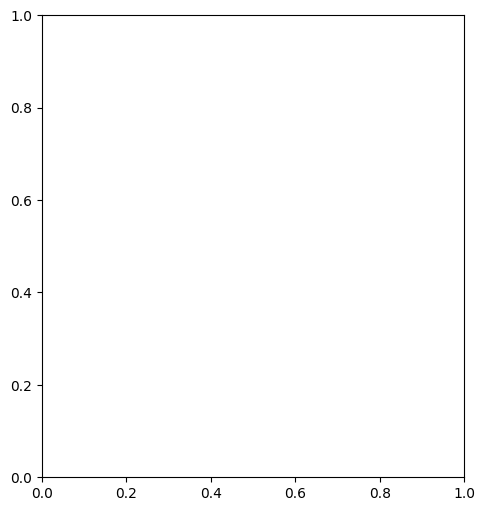

In [54]:
import matplotlib.pyplot as plt

for model_name, model in models.items():
    # Load history
    history = model.history

    # Plot accuracy and loss
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy')
    elif 'acc' in history.history:
        plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
